In [30]:
import errno
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
from scipy.ndimage import rotate
from scipy.stats import bernoulli

%matplotlib inline

In [31]:
# Some useful constants
DRIVING_LOG_FILE = os.getcwd() + '/data/driving_log.csv'
IMG_PATH = os.getcwd() + '/'

In [32]:
def crop(image, top_percent, bottom_percent):
    """
    Crops an image according to the given parameters

    :param image: source image

    :param top_percent:
        The percentage of the original image will be cropped from the top of the image

    :param bottom_percent:
        The percentage of the original image will be cropped from the bottom of the image

    :return:
        The cropped image
    """
    assert 0 <= top_percent < 0.5, 'top_percent should be between 0.0 and 0.5'
    assert 0 <= bottom_percent < 0.5, 'top_percent should be between 0.0 and 0.5'

    top = int(np.ceil(image.shape[0] * top_percent))
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))

    return image[top:bottom, :]

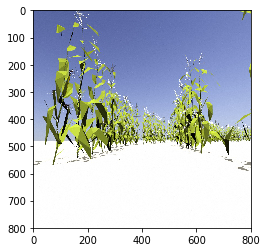

In [33]:
img = cv2.imread('images/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

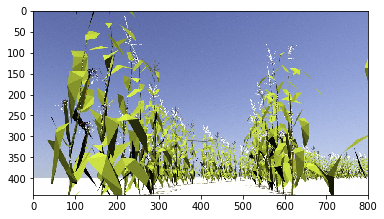

In [34]:
cropped_img = crop(img, 0.1, 0.35)
plt.imshow(cropped_img)
plt.show()

In [35]:
def random_flip(image, steering_angle, flipping_prob=0.5):
    """
    Based on the outcome of an coin flip, the image will be flipped.
    If flipping is applied, the steering angle will be negated.

    :param image: Source image

    :param steering_angle: Original steering angle

    :return: Both flipped image and new steering angle
    """
    head = bernoulli.rvs(flipping_prob)
    if head:
        return np.fliplr(image), -1 * steering_angle
    else:
        return image, steering_angle

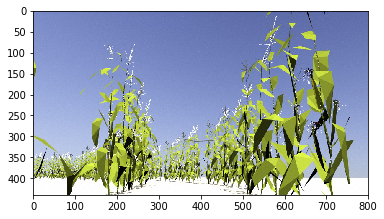

In [36]:
flipped_img, _ = random_flip(cropped_img, 0.1, 1)
plt.imshow(flipped_img)
plt.show()

In [37]:
def random_gamma(image):
    """
    Random gamma correction is used as an alternative method changing the brightness of
    training images.
    http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/

    :param image:
        Source image

    :return:
        New image generated by applying gamma correction to the source image
    """
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

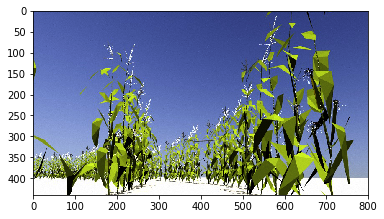

In [38]:
gamma_img = random_gamma(flipped_img)
plt.imshow(gamma_img)
plt.show()

In [39]:
def random_shear(image, steering_angle, shear_range=200):
    """
    Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk

    :param image:
        Source image on which the shear operation will be applied

    :param steering_angle:
        The steering angle of the image

    :param shear_range:
        Random shear between [-shear_range, shear_range + 1] will be applied

    :return:
        The image generated by applying random shear on the source image
    """
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return image, steering_angle

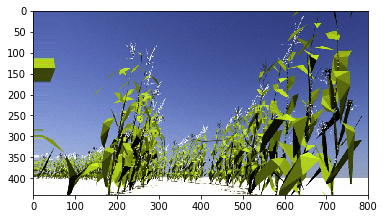

In [40]:
sheared_img, _ = random_shear(gamma_img, 0.1)
plt.imshow(sheared_img)
plt.show()

/Users/karan/.virtualenvs/dlearn/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


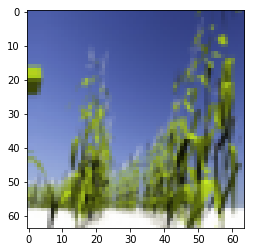

In [41]:
resize_dim=(64, 64)
resized_img = scipy.misc.imresize(sheared_img, resize_dim)
plt.imshow(resized_img)
plt.show()

In [42]:
import pandas as pd

data_frame = pd.read_csv('data/driving_log.csv', usecols=[0,1,2])

data_frame.describe(include='all')

,image,time,steering
count,2135,2135.000000,2135.000000
unique,2135,NaN,NaN
top,data/IMG/1935.jpg,NaN,NaN
freq,1,NaN,NaN
mean,NaN,302603.536300,-0.265646
std,NaN,128958.469292,0.607431
min,NaN,75250.000000,-1.500000
25%,NaN,197325.000000,-0.669832
50%,NaN,289850.000000,0.000000
75%,NaN,395075.000000,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1168c9e80>]], dtype=object)

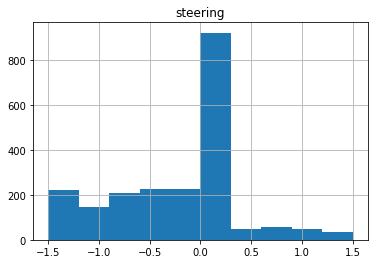

In [43]:
data_frame.hist(column='steering')